In [29]:
import csv
from itertools import count
from functools import partial
from operator import itemgetter

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

from util import stats, TreeNode

In [2]:
# start Spark Session
from pyspark.sql import SparkSession
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel, LabeledPoint, RandomForest

app_name = "w261_tree_scratch"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [3]:
rawRDD = spark.read.csv("data/sample.txt", header=False, sep="\t").rdd
dataRDD = rawRDD.map(lambda row: ([None if el is None else int(el) for el in row[1:14]] + list(row[14:]), int(row[0])))

In [4]:
# load the data we saved from the EDA. This helps us engineer the features and configure the model

frequent_feats = {}

with open("data/freq_category_counts.csv") as csvfile:
    for row in csv.DictReader(csvfile):
        total = int(row["total"])
        if total >= 10:
            key = "{}-{}".format(row["col_name"], row["category"])
            frequent_feats[key] = int(row["category_id"])

with open("data/num_significant_categories.csv") as csvfile:
    num_significant_categories = { row["field"]: int(row["count"]) for row in csv.DictReader(csvfile) }

In [5]:
def to_labeled(pair):
    """transform input data into the features"""
    row, label = pair
    # collect the converted values here
    vector = []
    
    for i, val in enumerate(row):
        # if this is an numerical column
        if i < 13:
            if val is None:
                val = -10
        # if this is categorical
        else:
            if val is not None:
                key = "C{}-{}".format(i - 13, val)
                # if its one of our "common" values
                if key in frequent_feats:
                    # look up its ID
                    val = frequent_feats[key]
                else:
                    # give it the special value for RARE
                    val = num_significant_categories["C" + str(i - 13)]
            else:
                # give it the special value for NULL
                val = num_significant_categories["C" + str(i - 13)] + 1
        vector.append(val)
    return LabeledPoint(label, vector)

def resample(pair):
    """sample the positive examples twice to increase their importance"""
    if pair.label == 1:
        return [pair, pair]
    else:
        return [pair]

labeledRDD = dataRDD.map(to_labeled)

# set model params
categoricalFeaturesInfo = { int(feat[1:]) + 13: count + 2 for feat, count in num_significant_categories.items() }
maxBins = max(num_significant_categories.values()) + 2
trainingData, validationData = labeledRDD.randomSplit([0.9, 0.1])
# re-samples the positive class
#trainingData = trainingData.flatMap(resample)

labels = validationData.map(lambda lp: lp.label).collect()

In [25]:
class DecisionTreeBinaryClassifier:
    def __init__(self, num_features, categorical_features_info, max_bins=32, max_depth=10):
        self.num_features = num_features
        self.categorical_features_info = categorical_features_info
        self.max_bins = max_bins
        self.max_depth = max_depth
    
    def train(self, dataRDD):
        print(dataRDD.take(5))
        node_id_counter = count()
        def seq_op(counts, row):
            label = row[0]
            counts[int(label)] += 1
            return counts
        comb_op = lambda counts1, counts2: [counts1[0] + counts2[0], counts1[1] + counts2[1]]
        label_counts = dataRDD.aggregate([0, 0], seq_op, comb_op)
        n, probability, gini = stats(label_counts)

        fraction = sample_fraction_for_accurate_splits(n, self.max_bins)
        sample = dataRDD.sample(withReplacement=False, fraction=fraction)
        continuous_bins = sample.flatMap(spread_row) \
            .groupByKey() \
            .mapValues(partial(to_bins, self.max_bins)) \
            .collectAsMap()
        treeRDD = dataRDD.map(lambda pair: (pair[0], discretize(continuous_bins, pair[1])))
        self.continuous_bins = continuous_bins
        
        tree_root = TreeNode(next(node_id_counter), n, gini, probability)
        self.tree_root = tree_root
        print(tree_root)
        frontier = [tree_root]
        depth = 0
        while len(frontier) > 0:
            print(depth)
            candidate_splits = {}
            for node in frontier:
                candidate_splits[node.id] = gen_candidate_splits(self.num_features, self.max_bins, self.categorical_features_info)
            statsRDD = treeRDD.flatMap(partial(split_statistics, tree_root, candidate_splits)) \
                .reduceByKey(result_adder) \
                .mapValues(to_gini)
            best_splits = statsRDD.map(shift_key) \
                .reduceByKey(get_purest_split) \
                .collectAsMap()
            print(best_splits)
            new_frontier = []
            for node in frontier:
                split_data = best_splits[node.id]
                (split_feat, split_val), _, (left_n, left_proba, left_gini), (right_n, right_proba, right_gini) = split_data
                left = TreeNode(next(node_id_counter), left_n, left_gini, left_proba)
                right = TreeNode(next(node_id_counter), right_n, right_gini, right_proba)
                node.split(split_feat, split_val, left, right)
                new_frontier.append(left)
                new_frontier.append(right)
            depth += 1
            if depth >= self.max_depth:
                frontier = []
            else:
                frontier = new_frontier
        print(tree_root)
    
    def predict(self, dataRDD):
        return dataRDD.map(partial(discretize, self.continuous_bins)) \
            .map(self.tree_root.get_probability)


def sample_fraction_for_accurate_splits(total_num_rows, max_bins):
    """
    determines how many rows to sample from the RDD in order to calculate the bins for discretizing continuous values
    uses same heuristic as Spark MLlib
    https://github.com/apache/spark/blob/ebd899b8a865395e6f1137163cb508086696879b/mllib/src/main/scala/org/apache/spark/ml/tree/impl/RandomForest.scala#L1168-L1177
    """
    required_samples = max(max_bins * max_bins, 10_000)
    if required_samples >= total_num_rows:
        return 1
    return required_samples / total_num_rows

def spread_row(row):
    return [ (i, val) for i, val in enumerate(row[1]) if val != 0 ]

def to_bins(max_bins, sample):
    return np.quantile(list(sample), np.linspace(0, 1, max_bins + 1)[1:-1])

def discretize(bins, feat_vector):
    binned_feat_vector = []
    for i, val in enumerate(feat_vector):
        binned_feat_vector.append(to_discrete(val, bins[i]))
    return binned_feat_vector

def to_discrete(continuous_val, bins):
    for i in range(0, len(bins)):
        if continuous_val < bins[i]:
            return i
    return len(bins)

def gen_candidate_splits(num_feats, num_bins, categorical_features_info):
    # TODO: make this respect restricted ranges as depth grows
    candidates = {}
    for i in range(num_feats):
        candidates[i] = list(range(num_bins - 1))
    return candidates

def split_statistics(tree_root, candidate_splits, pair):
    label, feat_vector = pair
    node_assignment = tree_root.get_assigned_node_id(feat_vector)
    candidates_to_evaluate = candidate_splits[node_assignment]

    for feat_idx, split_vals in candidates_to_evaluate.items():
        for split_val in split_vals:
            results = [[0, 0], [0, 0]]
            to_right = feat_vector[feat_idx] > split_val
            results[int(to_right)][int(label)] = 1
            yield (node_assignment, feat_idx, split_val), results

def result_adder(results1, results2):
    return [[results1[0][0] + results2[0][0], results1[0][1] + results2[0][1]],
            [results1[1][0] + results2[1][0], results1[1][1] + results2[1][1]]]

def to_gini(results):
    results1, results2 = results
    stats1 = stats(results1)
    stats2 = stats(results2)
    if stats1[2] is np.inf or stats2[2] is np.inf:
        return np.inf, stats1, stats2
    total = stats1[0] + stats2[0]
    return stats1[0] / total * stats1[2] + stats2[0] / total * stats2[2], stats1, stats2

def shift_key(pair):
    tuple_key, tuple_data = pair
    return (tuple_key[0], (tuple_key[1:],) + tuple_data)

def get_purest_split(data1, data2):
    if data1[1] < data2[1]:
        return data1
    return data2

In [9]:
import matplotlib.pyplot as plt

n = 30000

pos = np.random.multivariate_normal((4, 0), ((1., -0.5), (-0.5, 1.)), n)
pos = np.hstack((pos, np.ones((n, 1))))
neg = np.random.multivariate_normal((5.5, 1.5), ((1., -0.5), (-0.5, 1.)), n)
neg = np.hstack((neg, np.zeros((n, 1))))

data = np.vstack((pos, neg))
np.random.shuffle(data)

toyRDD = sc.parallelize(data).map(lambda row: (row[-1], row[:-1]))

In [ ]:
tree = DecisionTreeBinaryClassifier(2, {}, max_depth=6)
tree.train(toyRDD)

In [34]:
probs = tree.predict(toyRDD.map(itemgetter(1))).collect()
predictions = np.round(probs)
accuracy = np.mean(predictions == data[:, 2])
print(accuracy)
print(confusion_matrix(data[:, 2], predictions))
print(classification_report(data[:, 2], predictions))

0.9306833333333333
[[27713  2287]
 [ 1872 28128]]
             precision    recall  f1-score   support

        0.0       0.94      0.92      0.93     30000
        1.0       0.92      0.94      0.93     30000

avg / total       0.93      0.93      0.93     60000



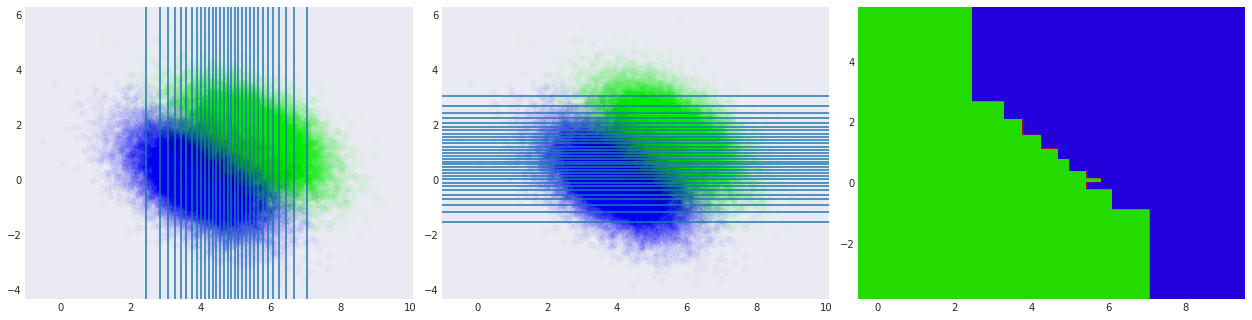

In [86]:
colors = np.array([[0., 1., 0., 0.02] if label == 0 else [0., 0., 1., 0.02] for label in data[:, 2]])

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(data[:, 0], data[:, 1], c=colors)
for i in tree.continuous_bins[0]:
    plt.axvline(x=i)

plt.subplot(1, 3, 2)
plt.scatter(data[:, 0], data[:, 1], c=colors)
for i in tree.continuous_bins[1]:
    plt.axhline(y=i)
    
plt.subplot(1, 3, 3)
plot_step = 0.02

x_min, x_max = data[:, 0].min(), data[:, 0].max()
y_min, y_max = data[:, 1].min(), data[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

meshRDD = sc.parallelize(np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1))))
z = tree.predict(meshRDD).collect()
z = np.array(z).round().reshape(xx.shape)
cs = plt.contourf(xx, yy, z, cmap=plt.cm.brg)